# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Fri Jan 15 22:31:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P8    12W / 151W |    486MiB /  8192MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019

01/07/2021  06:43 AM    <DIR>          .
01/07/2021  06:43 AM    <DIR>          ..
12/18/2019  03:27 AM            54,948 aptos_train.csv
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash - Copy.csv
12/26/2020  12:59 PM           702,068 df_train_dhash - Copy.xlsx
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
01/15/2021  07:33 PM    <DIR>          models
01/04/2021  07:50 PM    <DIR>          models - Copy
12/21/2020  07:33 AM    30,245,087,887 models.7z
01/07/2021  12:14 PM    <DIR>          models_alpha
01/06/2021  10:12 AM    <DIR>          models_without_l2
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/17/2020  02:28 PM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/17/2020  02:28 PM            54,948 train.csv
01/06/2021  11:23 PM    <DIR>        

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019/'
dir_img = os.path.join(dir_base,
                       'train_images_300/train_images_rescaled_300_jpeg_72')

if os.path.isdir(os.path.join(dir_base,
                              'models/kfold_rescale_jpeg_72/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale_jpeg_72/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
save_csv = 'log_training.csv'
save_EOE_train_head = 'EOE_classifier.h5'
save_best_train_head = 'best_classifier.h5'
save_EOE_train_body = 'EOE_fine_tune.h5'
save_best_train_body = 'best_fine_tune.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df['id_code'] = df['id_code'].str.replace('.png', '.jpeg')
df

,id_code,diagnosis
0,000c1434d8d7.jpeg,2
1,001639a390f0.jpeg,4
2,0024cdab0c1e.jpeg,1
3,002c21358ce6.jpeg,0
4,005b95c28852.jpeg,0
...,...,...
3493,ffa47f6a7bf4.jpeg,2
3494,ffc04fed30e6.jpeg,0
3495,ffcf7b45f213.jpeg,2
3496,ffd97f8cd5aa.jpeg,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']], df.iloc[
    dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(include_top=False,
                            weights='imagenet',
                            input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512,
                     kernel_initializer=initializers.GlorotUniform(seed=123),
                     kernel_regularizer='l2',
                     bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()
]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         fill_mode='reflect',
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         data_format='channels_last')

test_datagen = image.ImageDataGenerator(data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.jpeg'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.jpeg,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

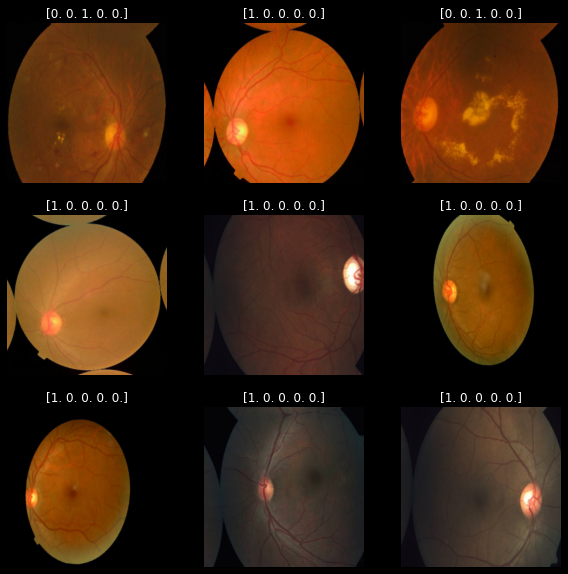

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.jpeg'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.jpeg,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

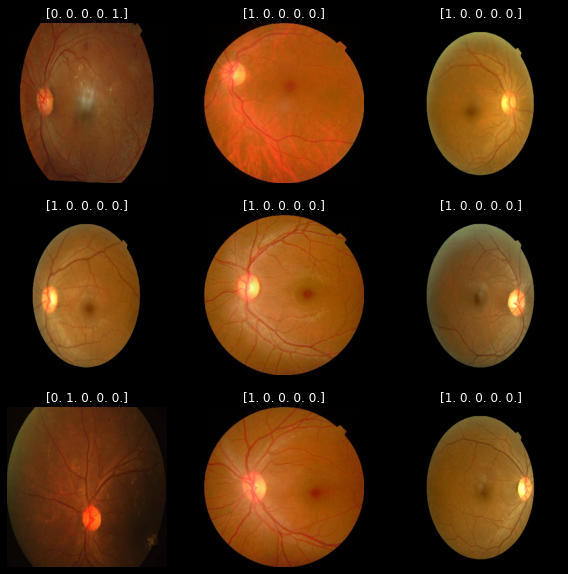

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [ ]:
try:
    del (model)
except:
    pass

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.jpeg,2
5,0083ee8054ee.jpeg,4
9,00cb6555d108.jpeg,1


In [37]:
if os.path.isdir(
        os.path.join(dir_base, 'models/kfold_rescale_jpeg_72/fold' +
                     str(fold))) == False:
    os.mkdir(
        os.path.join(dir_base,
                     'models/kfold_rescale_jpeg_72/fold' + str(fold)))

save_dir = os.path.join(dir_base,
                        'models/kfold_rescale_jpeg_72/fold' + str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_init),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_head),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [41]:
history = model.fit(train_generator,
                    epochs=epoch_init,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.8085 - categorical_accuracy: 0.4837 - precision: 0.5689 - recall: 0.3984 - auc: 0.7635
Epoch 00001: val_loss improved from inf to 10.08587, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_classifier.h5
88/88 [==============================] - 177s 2s/step - loss: 10.7998 - categorical_accuracy: 0.4839 - precision: 0.5695 - recall: 0.3985 - auc: 0.7642 - val_loss: 10.0859 - val_categorical_accuracy: 0.5857 - val_precision: 0.8859 - val_recall: 0.3771 - val_auc: 0.8529
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1933 - categorical_accuracy: 0.5658 - precision: 0.6558 - recall: 0.4960 - auc: 0.8343
Epoch 00002: val_loss improved from 10.08587 to 9.65325, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.2684 - categorical_accuracy: 0.6800 - precision: 0.7517 - recall: 0.6052 - auc: 0.9199
Epoch 00015: val_loss improved from 6.34566 to 6.13743, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_classifier.h5
88/88 [==============================] - 121s 1s/step - loss: 6.2661 - categorical_accuracy: 0.6801 - precision: 0.7519 - recall: 0.6054 - auc: 0.9199 - val_loss: 6.1374 - val_categorical_accuracy: 0.6843 - val_precision: 0.7942 - val_recall: 0.5900 - val_auc: 0.9277
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 6.0374 - categorical_accuracy: 0.6923 - precision: 0.7496 - recall: 0.6157 - auc: 0.9221
Epoch 00016: val_loss improved from 6.13743 to 5.91366, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_classifier.h5
88/88 [==============================] - 122s 1s/step - loss: 6.0371 - categorical_accuracy: 0.6923 

87/88 [============================>.] - ETA: 1s - loss: 2.5327 - categorical_accuracy: 0.7437 - precision: 0.8062 - recall: 0.6721 - auc: 0.9491
Epoch 00043: val_loss improved from 2.72262 to 2.66837, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_classifier.h5
88/88 [==============================] - 122s 1s/step - loss: 2.5277 - categorical_accuracy: 0.7448 - precision: 0.8069 - recall: 0.6733 - auc: 0.9494 - val_loss: 2.6684 - val_categorical_accuracy: 0.7200 - val_precision: 0.7872 - val_recall: 0.6343 - val_auc: 0.9387
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.4707 - categorical_accuracy: 0.7538 - precision: 0.8159 - recall: 0.6844 - auc: 0.9506
Epoch 00044: val_loss improved from 2.66837 to 2.59173, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_classifier.h5
88/88 [==============================] - 121s 1s/step - loss: 2.4706 - categorical_accuracy: 0.7538 - precision:

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

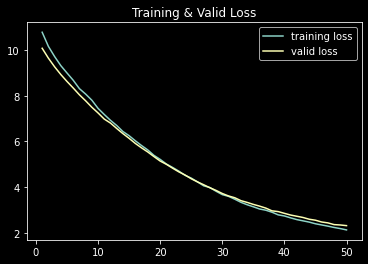

In [43]:
plot_loss(history)

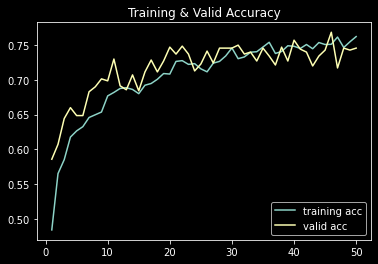

In [44]:
plot_acc(history)

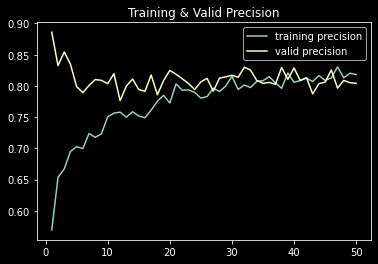

In [45]:
plot_precision(history)

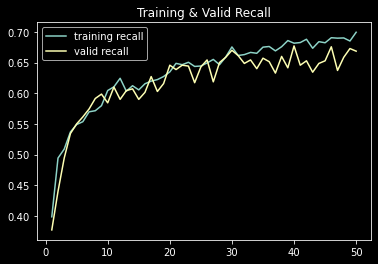

In [46]:
plot_recall(history)

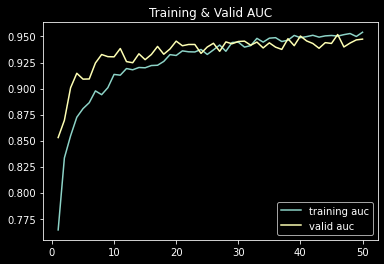

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 478ms/step - loss: 2.0054 - categorical_accuracy: 0.7457 - precision: 0.8041 - recall: 0.6686 - auc: 0.9474


[2.005379844795574, 0.7457143, 0.8041237, 0.6685714, 0.9474443]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 9s 421ms/step


In [51]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       359
         mild       0.50      0.51      0.50        67
     moderate       0.70      0.46      0.55       185
       severe       0.30      0.71      0.43        35
proliferative       0.43      0.50      0.46        54

     accuracy                           0.75       700
    macro avg       0.58      0.63      0.58       700
 weighted avg       0.77      0.75      0.75       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   1,   1,   0],
       [  8,  34,  21,   2,   2],
       [  5,  24,  85,  41,  30],
       [  0,   0,   6,  25,   4],
       [  1,   4,   9,  13,  27]], dtype=int64)

## Fine Tune

In [53]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_tune),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [55]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_body),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [56]:
history = model.fit(train_generator,
                    epochs=epoch_tune,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0660 - categorical_accuracy: 0.7748 - precision: 0.8265 - recall: 0.7061 - auc: 0.9555
Epoch 00001: val_loss improved from inf to 2.31323, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_fine_tune.h5
88/88 [==============================] - 137s 2s/step - loss: 2.0659 - categorical_accuracy: 0.7752 - precision: 0.8274 - recall: 0.7059 - auc: 0.9557 - val_loss: 2.3132 - val_categorical_accuracy: 0.7486 - val_precision: 0.8048 - val_recall: 0.6714 - val_auc: 0.9466
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0648 - categorical_accuracy: 0.7751 - precision: 0.8262 - recall: 0.7097 - auc: 0.9569
Epoch 00002: val_loss improved from 2.31323 to 2.30857, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_fine_tune.h5
88/88 [=========

87/88 [============================>.] - ETA: 1s - loss: 1.9335 - categorical_accuracy: 0.7907 - precision: 0.8407 - recall: 0.7480 - auc: 0.9671
Epoch 00030: val_loss improved from 2.21401 to 2.21324, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_fine_tune.h5
88/88 [==============================] - 122s 1s/step - loss: 1.9320 - categorical_accuracy: 0.7924 - precision: 0.8418 - recall: 0.7495 - auc: 0.9673 - val_loss: 2.2132 - val_categorical_accuracy: 0.7529 - val_precision: 0.8006 - val_recall: 0.7057 - val_auc: 0.9532
Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.9279 - categorical_accuracy: 0.8044 - precision: 0.8536 - recall: 0.7527 - auc: 0.9679
Epoch 00031: val_loss improved from 2.21324 to 2.21316, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_fine_tune.h5
88/88 [==============================] - 121s 1s/step - loss: 1.9253 - categorical_accuracy: 0.8049 - precision: 0

Epoch 45/50
87/88 [============================>.] - ETA: 1s - loss: 1.8533 - categorical_accuracy: 0.8304 - precision: 0.8673 - recall: 0.7845 - auc: 0.9735
Epoch 00045: val_loss improved from 2.18614 to 2.18471, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_fine_tune.h5
88/88 [==============================] - 122s 1s/step - loss: 1.8508 - categorical_accuracy: 0.8317 - precision: 0.8680 - recall: 0.7848 - auc: 0.9738 - val_loss: 2.1847 - val_categorical_accuracy: 0.7714 - val_precision: 0.8078 - val_recall: 0.7143 - val_auc: 0.9538
Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.8460 - categorical_accuracy: 0.8131 - precision: 0.8503 - recall: 0.7683 - auc: 0.9712
Epoch 00046: val_loss improved from 2.18471 to 2.18315, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold1\best_fine_tune.h5
88/88 [==============================] - 122s 1s/step - loss: 1.8446 - categorical_accuracy: 0.8142 - 

In [57]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

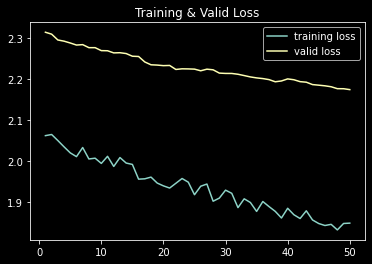

In [58]:
plot_loss(history)

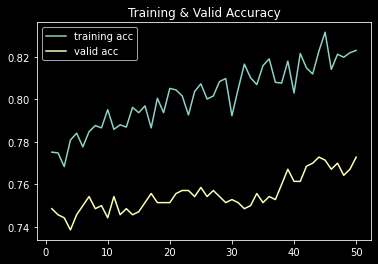

In [59]:
plot_acc(history)

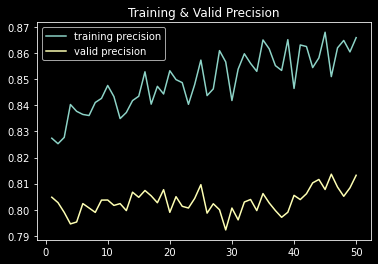

In [60]:
plot_precision(history)

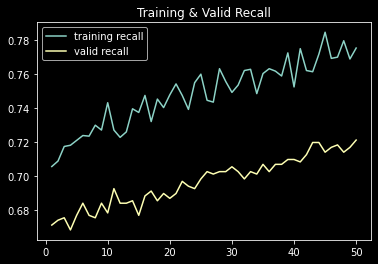

In [61]:
plot_recall(history)

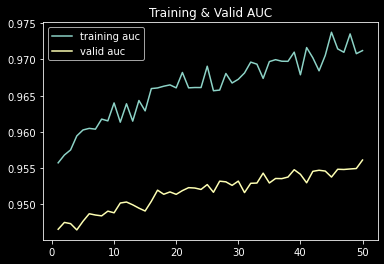

In [62]:
plot_auc(history)

### Evaluate model

In [63]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 481ms/step - loss: 1.8825 - categorical_accuracy: 0.7729 - precision: 0.8132 - recall: 0.7214 - auc: 0.9561


[1.8824888305230574, 0.7728571, 0.8132045, 0.7214286, 0.9561299]

In [64]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [65]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 465ms/step


In [66]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.97      0.97       359
         mild       0.51      0.64      0.57        67
     moderate       0.74      0.54      0.62       185
       severe       0.35      0.60      0.44        35
proliferative       0.48      0.56      0.52        54

     accuracy                           0.77       700
    macro avg       0.61      0.66      0.62       700
 weighted avg       0.80      0.77      0.78       700



In [67]:
confusion_matrix(y_true, y_pred)

array([[347,  10,   2,   0,   0],
       [  7,  43,  15,   0,   2],
       [  4,  28, 100,  28,  25],
       [  0,   1,   8,  21,   5],
       [  1,   2,  10,  11,  30]], dtype=int64)

# Fold 2

## Train classifier

In [68]:
try:
    del (model)
except:
    pass

In [69]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [70]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.jpeg,4
3,002c21358ce6.jpeg,0
11,00e4ddff966a.jpeg,2


In [71]:
if os.path.isdir(
        os.path.join(dir_base, 'models/kfold_rescale_jpeg_72/fold' +
                     str(fold))) == False:
    os.mkdir(
        os.path.join(dir_base,
                     'models/kfold_rescale_jpeg_72/fold' + str(fold)))

save_dir = os.path.join(dir_base,
                        'models/kfold_rescale_jpeg_72/fold' + str(fold))

In [72]:
conv_base, model = create_model()

In [73]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_init),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [74]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_head),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [75]:
history = model.fit(train_generator,
                    epochs=epoch_init,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7885 - categorical_accuracy: 0.4794 - precision: 0.5602 - recall: 0.3952 - auc: 0.7628
Epoch 00001: val_loss improved from inf to 10.14144, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_classifier.h5
88/88 [==============================] - 134s 2s/step - loss: 10.7847 - categorical_accuracy: 0.4800 - precision: 0.5604 - recall: 0.3960 - auc: 0.7632 - val_loss: 10.1414 - val_categorical_accuracy: 0.5814 - val_precision: 0.8757 - val_recall: 0.4229 - val_auc: 0.8569
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0879 - categorical_accuracy: 0.5770 - precision: 0.6534 - recall: 0.4996 - auc: 0.8410
Epoch 00002: val_loss improved from 10.14144 to 9.68189, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.0882 - categorical_accuracy: 0.6945 - precision: 0.7616 - recall: 0.6226 - auc: 0.9247
Epoch 00015: val_loss improved from 6.24559 to 6.01977, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_classifier.h5
88/88 [==============================] - 124s 1s/step - loss: 6.0824 - categorical_accuracy: 0.6959 - precision: 0.7627 - recall: 0.6226 - auc: 0.9253 - val_loss: 6.0198 - val_categorical_accuracy: 0.7600 - val_precision: 0.8174 - val_recall: 0.6586 - val_auc: 0.9471
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8627 - categorical_accuracy: 0.7126 - precision: 0.7836 - recall: 0.6403 - auc: 0.9305
Epoch 00016: val_loss improved from 6.01977 to 5.81473, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_classifier.h5
88/88 [==============================] - 121s 1s/step - loss: 5.8583 - categorical_accuracy: 0.7137 

87/88 [============================>.] - ETA: 1s - loss: 2.3920 - categorical_accuracy: 0.7668 - precision: 0.8243 - recall: 0.6952 - auc: 0.9530
Epoch 00043: val_loss improved from 2.67474 to 2.61324, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_classifier.h5
88/88 [==============================] - 122s 1s/step - loss: 2.3924 - categorical_accuracy: 0.7663 - precision: 0.8237 - recall: 0.6948 - auc: 0.9530 - val_loss: 2.6132 - val_categorical_accuracy: 0.7671 - val_precision: 0.8188 - val_recall: 0.6971 - val_auc: 0.9518
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3463 - categorical_accuracy: 0.7581 - precision: 0.8120 - recall: 0.6916 - auc: 0.9521
Epoch 00044: val_loss improved from 2.61324 to 2.54787, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_classifier.h5
88/88 [==============================] - 121s 1s/step - loss: 2.3464 - categorical_accuracy: 0.7580 - precision:

In [76]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

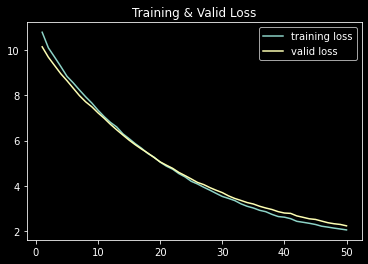

In [77]:
plot_loss(history)

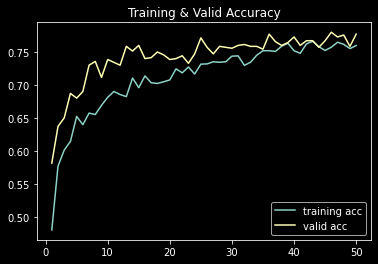

In [78]:
plot_acc(history)

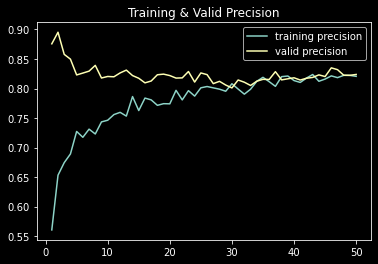

In [79]:
plot_precision(history)

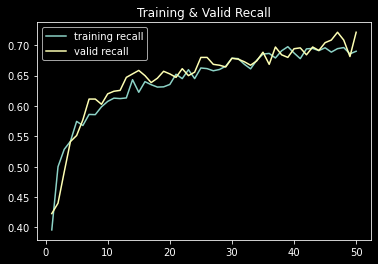

In [80]:
plot_recall(history)

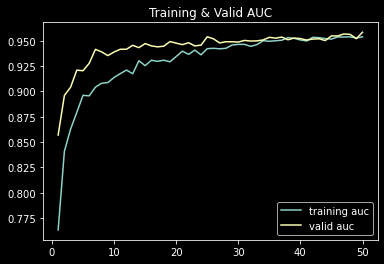

In [81]:
plot_auc(history)

### Evaluate model

In [82]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 485ms/step - loss: 1.8490 - categorical_accuracy: 0.7771 - precision: 0.8238 - recall: 0.7214 - auc: 0.9583


[1.8490404432470149, 0.7771429, 0.8238173, 0.7214286, 0.9583114]

In [83]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [84]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 495ms/step


In [85]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.98      0.97       359
         mild       0.51      0.59      0.55        68
     moderate       0.74      0.60      0.66       184
       severe       0.31      0.49      0.38        35
proliferative       0.44      0.46      0.45        54

     accuracy                           0.78       700
    macro avg       0.60      0.62      0.60       700
 weighted avg       0.79      0.78      0.78       700



In [86]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   1,   0,   1],
       [  4,  40,  17,   2,   5],
       [  5,  24, 111,  28,  16],
       [  0,   1,   7,  17,  10],
       [  1,   7,  14,   7,  25]], dtype=int64)

## Fine Tune

In [87]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_tune),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [89]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_body),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [90]:
history = model.fit(train_generator,
                    epochs=epoch_tune,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9911 - categorical_accuracy: 0.7773 - precision: 0.8340 - recall: 0.7119 - auc: 0.9569
Epoch 00001: val_loss improved from inf to 2.23410, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_fine_tune.h5
88/88 [==============================] - 137s 2s/step - loss: 1.9984 - categorical_accuracy: 0.7773 - precision: 0.8338 - recall: 0.7119 - auc: 0.9569 - val_loss: 2.2341 - val_categorical_accuracy: 0.7771 - val_precision: 0.8284 - val_recall: 0.7171 - val_auc: 0.9581
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9906 - categorical_accuracy: 0.7787 - precision: 0.8327 - recall: 0.7144 - auc: 0.9589
Epoch 00002: val_loss improved from 2.23410 to 2.23135, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold2\best_fine_tune.h5
88/88 [=========

Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8804 - categorical_accuracy: 0.8004 - precision: 0.8470 - recall: 0.7466 - auc: 0.9662
Epoch 00017: val_loss did not improve from 2.22439
88/88 [==============================] - 119s 1s/step - loss: 1.8765 - categorical_accuracy: 0.8016 - precision: 0.8483 - recall: 0.7473 - auc: 0.9665 - val_loss: 2.2332 - val_categorical_accuracy: 0.7886 - val_precision: 0.8355 - val_recall: 0.7400 - val_auc: 0.9594
Epoch 18/50
87/88 [============================>.] - ETA: 1s - loss: 1.8584 - categorical_accuracy: 0.8124 - precision: 0.8577 - recall: 0.7538 - auc: 0.9668
Epoch 00018: val_loss did not improve from 2.22439
88/88 [==============================] - 119s 1s/step - loss: 1.8579 - categorical_accuracy: 0.8113 - precision: 0.8572 - recall: 0.7530 - auc: 0.9668 - val_loss: 2.2288 - val_categorical_accuracy: 0.7886 - val_precision: 0.8317 - val_recall: 0.7414 - val_auc: 0.9601
Epoch 19/50
87/88 [===========================

88/88 [==============================] - 122s 1s/step - loss: 1.7440 - categorical_accuracy: 0.8284 - precision: 0.8645 - recall: 0.7798 - auc: 0.9746 - val_loss: 2.1883 - val_categorical_accuracy: 0.7914 - val_precision: 0.8341 - val_recall: 0.7471 - val_auc: 0.9615
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.7302 - categorical_accuracy: 0.8377 - precision: 0.8736 - recall: 0.7918 - auc: 0.9765
Epoch 00049: val_loss did not improve from 2.18835
88/88 [==============================] - 119s 1s/step - loss: 1.7284 - categorical_accuracy: 0.8381 - precision: 0.8743 - recall: 0.7927 - auc: 0.9767 - val_loss: 2.2027 - val_categorical_accuracy: 0.7929 - val_precision: 0.8352 - val_recall: 0.7457 - val_auc: 0.9615
Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.7494 - categorical_accuracy: 0.8232 - precision: 0.8609 - recall: 0.7762 - auc: 0.9731
Epoch 00050: val_loss did not improve from 2.18835
88/88 [==============================] - 118s 

In [91]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

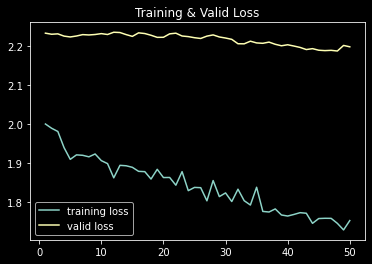

In [92]:
plot_loss(history)

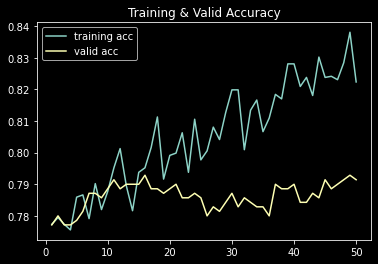

In [93]:
plot_acc(history)

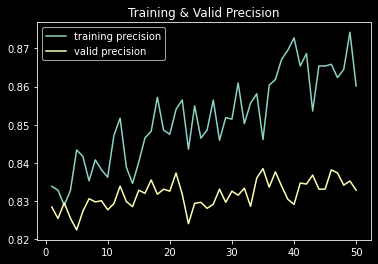

In [94]:
plot_precision(history)

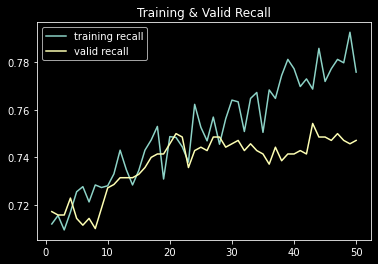

In [95]:
plot_recall(history)

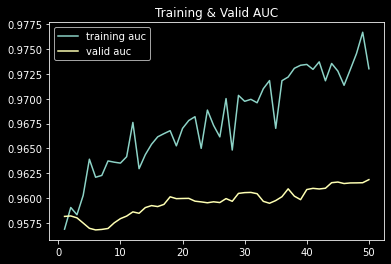

In [96]:
plot_auc(history)

### Evaluate model

In [97]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 485ms/step - loss: 1.7608 - categorical_accuracy: 0.7914 - precision: 0.8328 - recall: 0.7471 - auc: 0.9618


[1.7607886411926963, 0.79142857, 0.83280253, 0.74714285, 0.9618496]

In [98]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [99]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 9s 424ms/step


In [100]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.99      0.98       359
         mild       0.48      0.57      0.52        68
     moderate       0.75      0.64      0.69       184
       severe       0.33      0.46      0.38        35
proliferative       0.56      0.52      0.54        54

     accuracy                           0.79       700
    macro avg       0.62      0.63      0.62       700
 weighted avg       0.80      0.79      0.79       700



In [101]:
confusion_matrix(y_true, y_pred)

array([[354,   5,   0,   0,   0],
       [  4,  39,  19,   3,   3],
       [  4,  30, 117,  23,  10],
       [  1,   1,   8,  16,   9],
       [  1,   6,  12,   7,  28]], dtype=int64)

# Fold 3

## Train classifier

In [102]:
try:
    del (model)
except:
    pass

In [103]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [104]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.jpeg,1
12,00f6c1be5a33.jpeg,0
18,0151781fe50b.jpeg,0


In [105]:
if os.path.isdir(
        os.path.join(dir_base, 'models/kfold_rescale_jpeg_72/fold' +
                     str(fold))) == False:
    os.mkdir(
        os.path.join(dir_base,
                     'models/kfold_rescale_jpeg_72/fold' + str(fold)))

save_dir = os.path.join(dir_base,
                        'models/kfold_rescale_jpeg_72/fold' + str(fold))

In [106]:
conv_base, model = create_model()

In [107]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_init),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [108]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_head),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [109]:
history = model.fit(train_generator,
                    epochs=epoch_init,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7080 - categorical_accuracy: 0.4892 - precision: 0.5687 - recall: 0.3937 - auc: 0.7712
Epoch 00001: val_loss improved from inf to 10.17026, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_classifier.h5
88/88 [==============================] - 135s 2s/step - loss: 10.7072 - categorical_accuracy: 0.4886 - precision: 0.5692 - recall: 0.3939 - auc: 0.7713 - val_loss: 10.1703 - val_categorical_accuracy: 0.5786 - val_precision: 0.8114 - val_recall: 0.3443 - val_auc: 0.8395
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0881 - categorical_accuracy: 0.5734 - precision: 0.6600 - recall: 0.5033 - auc: 0.8463
Epoch 00002: val_loss improved from 10.17026 to 9.72761, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.0792 - categorical_accuracy: 0.6934 - precision: 0.7613 - recall: 0.6157 - auc: 0.9266
Epoch 00015: val_loss improved from 6.31065 to 6.08606, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_classifier.h5
88/88 [==============================] - 123s 1s/step - loss: 6.0761 - categorical_accuracy: 0.6944 - precision: 0.7627 - recall: 0.6169 - auc: 0.9269 - val_loss: 6.0861 - val_categorical_accuracy: 0.6943 - val_precision: 0.7786 - val_recall: 0.6029 - val_auc: 0.9303
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8060 - categorical_accuracy: 0.7144 - precision: 0.7883 - recall: 0.6515 - auc: 0.9350
Epoch 00016: val_loss improved from 6.08606 to 5.91690, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_classifier.h5
88/88 [==============================] - 122s 1s/step - loss: 5.8034 - categorical_accuracy: 0.7141 

87/88 [============================>.] - ETA: 1s - loss: 2.4020 - categorical_accuracy: 0.7755 - precision: 0.8247 - recall: 0.7057 - auc: 0.9556
Epoch 00043: val_loss improved from 2.77317 to 2.72353, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_classifier.h5
88/88 [==============================] - 121s 1s/step - loss: 2.4021 - categorical_accuracy: 0.7745 - precision: 0.8244 - recall: 0.7048 - auc: 0.9553 - val_loss: 2.7235 - val_categorical_accuracy: 0.7271 - val_precision: 0.7873 - val_recall: 0.6400 - val_auc: 0.9436
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3384 - categorical_accuracy: 0.7581 - precision: 0.8182 - recall: 0.6996 - auc: 0.9530
Epoch 00044: val_loss improved from 2.72353 to 2.67541, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_classifier.h5
88/88 [==============================] - 121s 1s/step - loss: 2.3449 - categorical_accuracy: 0.7573 - precision:

In [110]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

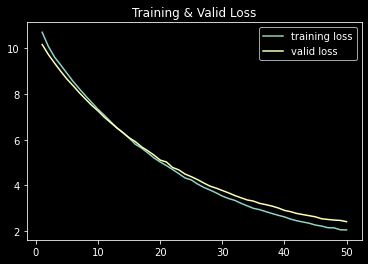

In [111]:
plot_loss(history)

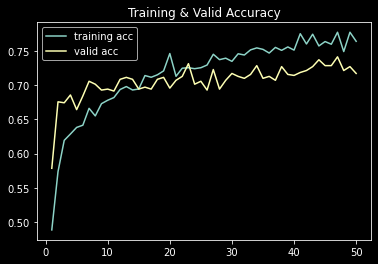

In [112]:
plot_acc(history)

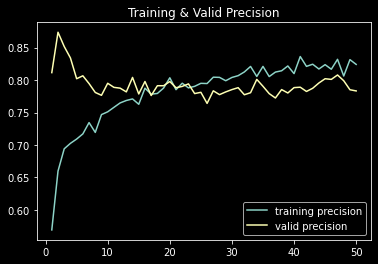

In [113]:
plot_precision(history)

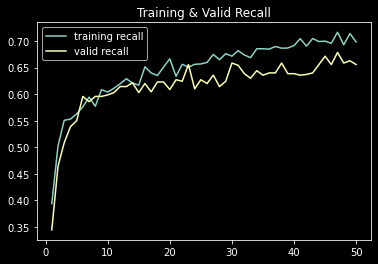

In [114]:
plot_recall(history)

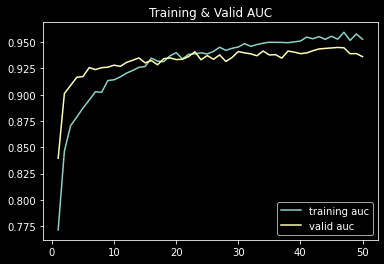

In [115]:
plot_auc(history)

### Evaluate model

In [116]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 483ms/step - loss: 2.0008 - categorical_accuracy: 0.7171 - precision: 0.7833 - recall: 0.6557 - auc: 0.9362


[2.000825421376662, 0.7171429, 0.78327644, 0.6557143, 0.93624204]

In [117]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [118]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 9s 422ms/step


In [119]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.43      0.47      0.45        68
     moderate       0.70      0.41      0.52       184
       severe       0.21      0.43      0.29        35
proliferative       0.38      0.56      0.45        54

     accuracy                           0.72       700
    macro avg       0.53      0.57      0.53       700
 weighted avg       0.75      0.72      0.72       700



In [120]:
confusion_matrix(y_true, y_pred)

array([[350,   7,   2,   0,   0],
       [ 10,  32,  13,   3,  10],
       [  9,  28,  75,  44,  28],
       [  0,   2,   7,  15,  11],
       [  1,   5,  10,   8,  30]], dtype=int64)

## Fine Tune

In [121]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [122]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_tune),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [123]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_body),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [124]:
history = model.fit(train_generator,
                    epochs=epoch_tune,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9860 - categorical_accuracy: 0.7769 - precision: 0.8364 - recall: 0.7097 - auc: 0.9584
Epoch 00001: val_loss improved from inf to 2.40215, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_fine_tune.h5
88/88 [==============================] - 140s 2s/step - loss: 1.9833 - categorical_accuracy: 0.7773 - precision: 0.8372 - recall: 0.7094 - auc: 0.9585 - val_loss: 2.4022 - val_categorical_accuracy: 0.7200 - val_precision: 0.7901 - val_recall: 0.6614 - val_auc: 0.9378
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9520 - categorical_accuracy: 0.7719 - precision: 0.8286 - recall: 0.7097 - auc: 0.9587
Epoch 00002: val_loss improved from 2.40215 to 2.39881, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_fine_tune.h5
88/88 [=========

Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.8547 - categorical_accuracy: 0.7975 - precision: 0.8485 - recall: 0.7469 - auc: 0.9675
Epoch 00016: val_loss did not improve from 2.37096
88/88 [==============================] - 119s 1s/step - loss: 1.8564 - categorical_accuracy: 0.7963 - precision: 0.8478 - recall: 0.7448 - auc: 0.9674 - val_loss: 2.3742 - val_categorical_accuracy: 0.7486 - val_precision: 0.7967 - val_recall: 0.7000 - val_auc: 0.9459
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8614 - categorical_accuracy: 0.7972 - precision: 0.8551 - recall: 0.7491 - auc: 0.9676
Epoch 00017: val_loss did not improve from 2.37096
88/88 [==============================] - 119s 1s/step - loss: 1.8589 - categorical_accuracy: 0.7981 - precision: 0.8560 - recall: 0.7502 - auc: 0.9679 - val_loss: 2.3737 - val_categorical_accuracy: 0.7443 - val_precision: 0.7919 - val_recall: 0.6957 - val_auc: 0.9455
Epoch 18/50
87/88 [===========================

Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.7804 - categorical_accuracy: 0.8196 - precision: 0.8596 - recall: 0.7722 - auc: 0.9718
Epoch 00033: val_loss improved from 2.34407 to 2.34084, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold3\best_fine_tune.h5
88/88 [==============================] - 122s 1s/step - loss: 1.7819 - categorical_accuracy: 0.8181 - precision: 0.8593 - recall: 0.7706 - auc: 0.9716 - val_loss: 2.3408 - val_categorical_accuracy: 0.7500 - val_precision: 0.7949 - val_recall: 0.7143 - val_auc: 0.9479
Epoch 34/50
87/88 [============================>.] - ETA: 1s - loss: 1.7897 - categorical_accuracy: 0.8156 - precision: 0.8639 - recall: 0.7690 - auc: 0.9709
Epoch 00034: val_loss did not improve from 2.34084
88/88 [==============================] - 119s 1s/step - loss: 1.7873 - categorical_accuracy: 0.8159 - precision: 0.8640 - recall: 0.7698 - auc: 0.9710 - val_loss: 2.3472 - val_categorical_accuracy: 0.7500 - v

Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.7494 - categorical_accuracy: 0.8308 - precision: 0.8619 - recall: 0.7852 - auc: 0.9736
Epoch 00049: val_loss did not improve from 2.32573
88/88 [==============================] - 119s 1s/step - loss: 1.7490 - categorical_accuracy: 0.8299 - precision: 0.8615 - recall: 0.7845 - auc: 0.9737 - val_loss: 2.3273 - val_categorical_accuracy: 0.7514 - val_precision: 0.7955 - val_recall: 0.7114 - val_auc: 0.9497
Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.7307 - categorical_accuracy: 0.8359 - precision: 0.8743 - recall: 0.7896 - auc: 0.9756
Epoch 00050: val_loss did not improve from 2.32573
88/88 [==============================] - 119s 1s/step - loss: 1.7358 - categorical_accuracy: 0.8352 - precision: 0.8738 - recall: 0.7895 - auc: 0.9756 - val_loss: 2.3300 - val_categorical_accuracy: 0.7586 - val_precision: 0.7991 - val_recall: 0.7214 - val_auc: 0.9501


In [125]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

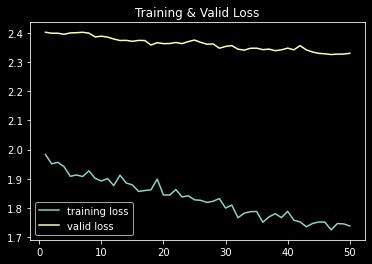

In [126]:
plot_loss(history)

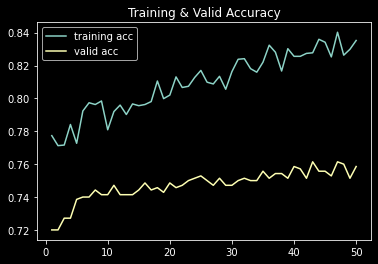

In [127]:
plot_acc(history)

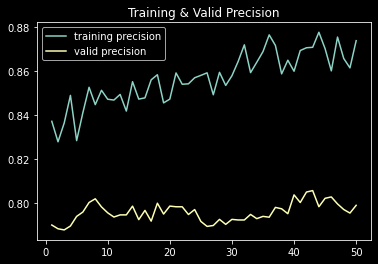

In [128]:
plot_precision(history)

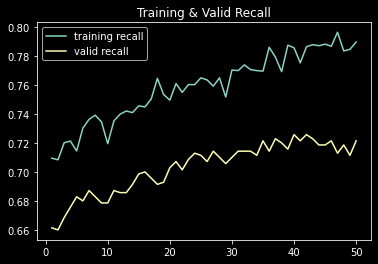

In [129]:
plot_recall(history)

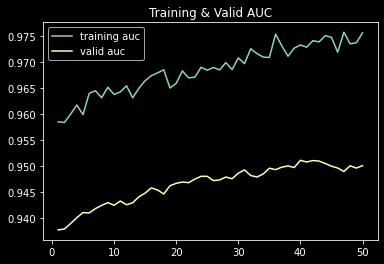

In [130]:
plot_auc(history)

### Evaluate model

In [131]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 491ms/step - loss: 1.8581 - categorical_accuracy: 0.7586 - precision: 0.7991 - recall: 0.7214 - auc: 0.9501


[1.85808635299856, 0.75857145, 0.7990506, 0.7214286, 0.950116]

In [132]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [133]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 9s 426ms/step


In [134]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       359
         mild       0.49      0.57      0.53        68
     moderate       0.69      0.57      0.62       184
       severe       0.27      0.34      0.30        35
proliferative       0.42      0.44      0.43        54

     accuracy                           0.76       700
    macro avg       0.57      0.58      0.57       700
 weighted avg       0.77      0.76      0.76       700



In [135]:
confusion_matrix(y_true, y_pred)

array([[351,   5,   3,   0,   0],
       [  7,  39,  17,   1,   4],
       [  8,  28, 105,  27,  16],
       [  0,   2,   8,  12,  13],
       [  1,   5,  19,   5,  24]], dtype=int64)

# Fold 4

## Train classifier

In [136]:
try:
    del (model)
except:
    pass

In [137]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [138]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.jpeg,0
10,00cc2b75cddd.jpeg,0
13,0104b032c141.jpeg,3


In [139]:
if os.path.isdir(
        os.path.join(dir_base, 'models/kfold_rescale_jpeg_72/fold' +
                     str(fold))) == False:
    os.mkdir(
        os.path.join(dir_base,
                     'models/kfold_rescale_jpeg_72/fold' + str(fold)))

save_dir = os.path.join(dir_base,
                        'models/kfold_rescale_jpeg_72/fold' + str(fold))

In [140]:
conv_base, model = create_model()

In [141]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_init),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [142]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_head),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [143]:
history = model.fit(train_generator,
                    epochs=epoch_init,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6918 - categorical_accuracy: 0.5031 - precision: 0.6000 - recall: 0.4218 - auc: 0.7813
Epoch 00001: val_loss improved from inf to 10.08707, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 10.6990 - categorical_accuracy: 0.5020 - precision: 0.5982 - recall: 0.4212 - auc: 0.7803 - val_loss: 10.0871 - val_categorical_accuracy: 0.6252 - val_precision: 0.8725 - val_recall: 0.4406 - val_auc: 0.8935
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0554 - categorical_accuracy: 0.5829 - precision: 0.6629 - recall: 0.5103 - auc: 0.8476
Epoch 00002: val_loss improved from 10.08707 to 9.59710, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.0803 - categorical_accuracy: 0.6964 - precision: 0.7702 - recall: 0.6249 - auc: 0.9258
Epoch 00015: val_loss improved from 6.14638 to 5.95968, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_classifier.h5
88/88 [==============================] - 122s 1s/step - loss: 6.0738 - categorical_accuracy: 0.6970 - precision: 0.7714 - recall: 0.6256 - auc: 0.9263 - val_loss: 5.9597 - val_categorical_accuracy: 0.7296 - val_precision: 0.7993 - val_recall: 0.6266 - val_auc: 0.9386
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8542 - categorical_accuracy: 0.7112 - precision: 0.7759 - recall: 0.6357 - auc: 0.9271
Epoch 00016: val_loss improved from 5.95968 to 5.74518, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_classifier.h5
88/88 [==============================] - 122s 1s/step - loss: 5.8580 - categorical_accuracy: 0.7113 

87/88 [============================>.] - ETA: 1s - loss: 2.4069 - categorical_accuracy: 0.7568 - precision: 0.8147 - recall: 0.6928 - auc: 0.9517
Epoch 00043: val_loss improved from 2.60834 to 2.56013, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_classifier.h5
88/88 [==============================] - 128s 1s/step - loss: 2.4069 - categorical_accuracy: 0.7556 - precision: 0.8139 - recall: 0.6920 - auc: 0.9513 - val_loss: 2.5601 - val_categorical_accuracy: 0.7454 - val_precision: 0.8265 - val_recall: 0.6681 - val_auc: 0.9481
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3808 - categorical_accuracy: 0.7449 - precision: 0.8038 - recall: 0.6794 - auc: 0.9457
Epoch 00044: val_loss improved from 2.56013 to 2.50816, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_classifier.h5
88/88 [==============================] - 124s 1s/step - loss: 2.3829 - categorical_accuracy: 0.7446 - precision:

In [144]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

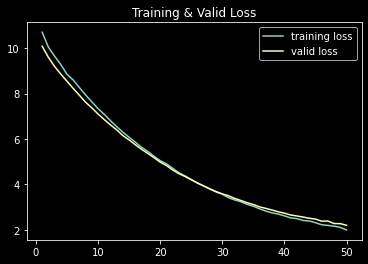

In [145]:
plot_loss(history)

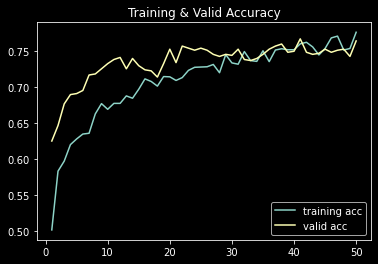

In [146]:
plot_acc(history)

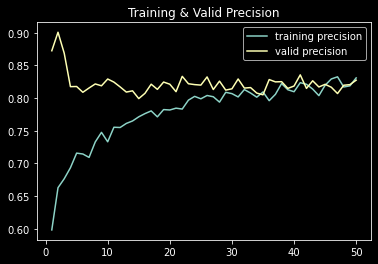

In [147]:
plot_precision(history)

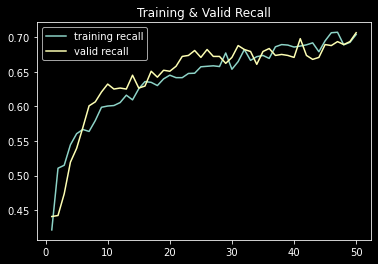

In [148]:
plot_recall(history)

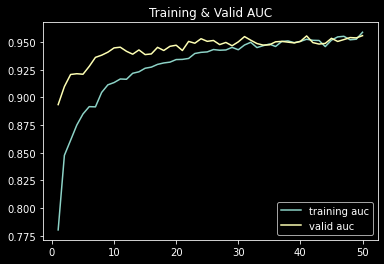

In [149]:
plot_auc(history)

### Evaluate model

In [150]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 509ms/step - loss: 1.8703 - categorical_accuracy: 0.7639 - precision: 0.8275 - recall: 0.7067 - auc: 0.9557


[1.870280233296481, 0.7639485, 0.82747066, 0.70672387, 0.95571154]

In [151]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [152]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 590ms/step


In [153]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       359
         mild       0.45      0.56      0.50        68
     moderate       0.71      0.60      0.65       184
       severe       0.40      0.53      0.46        34
proliferative       0.39      0.41      0.40        54

     accuracy                           0.76       699
    macro avg       0.58      0.61      0.59       699
 weighted avg       0.78      0.76      0.77       699



In [154]:
confusion_matrix(y_true, y_pred)

array([[346,  11,   1,   0,   1],
       [  7,  38,  22,   0,   1],
       [  6,  29, 110,  17,  22],
       [  0,   1,   4,  18,  11],
       [  0,   5,  17,  10,  22]], dtype=int64)

## Fine Tune

In [155]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [156]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_tune),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [157]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_body),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [158]:
history = model.fit(train_generator,
                    epochs=epoch_tune,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0012 - categorical_accuracy: 0.7665 - precision: 0.8231 - recall: 0.7112 - auc: 0.9571
Epoch 00001: val_loss improved from inf to 2.19315, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_fine_tune.h5
88/88 [==============================] - 138s 2s/step - loss: 2.0014 - categorical_accuracy: 0.7674 - precision: 0.8246 - recall: 0.7120 - auc: 0.9572 - val_loss: 2.1931 - val_categorical_accuracy: 0.7582 - val_precision: 0.8300 - val_recall: 0.7053 - val_auc: 0.9567
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9852 - categorical_accuracy: 0.7774 - precision: 0.8307 - recall: 0.7167 - auc: 0.9573
Epoch 00002: val_loss improved from 2.19315 to 2.18524, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_fine_tune.h5
88/88 [=========

Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.8150 - categorical_accuracy: 0.8160 - precision: 0.8568 - recall: 0.7698 - auc: 0.9684
Epoch 00031: val_loss improved from 2.12815 to 2.12684, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_fine_tune.h5
88/88 [==============================] - 126s 1s/step - loss: 1.8147 - categorical_accuracy: 0.8153 - precision: 0.8563 - recall: 0.7688 - auc: 0.9682 - val_loss: 2.1268 - val_categorical_accuracy: 0.7868 - val_precision: 0.8304 - val_recall: 0.7425 - val_auc: 0.9601
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.8258 - categorical_accuracy: 0.8088 - precision: 0.8595 - recall: 0.7604 - auc: 0.9689
Epoch 00032: val_loss improved from 2.12684 to 2.12071, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_fine_tune.h5
88/88 [==============================] - 124s 1s/step - loss: 1.8258 - categorical_accuracy: 0.8085 - 

Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.7785 - categorical_accuracy: 0.8204 - precision: 0.8633 - recall: 0.7738 - auc: 0.9713
Epoch 00046: val_loss did not improve from 2.09061
88/88 [==============================] - 122s 1s/step - loss: 1.7762 - categorical_accuracy: 0.8210 - precision: 0.8637 - recall: 0.7746 - auc: 0.9715 - val_loss: 2.0914 - val_categorical_accuracy: 0.7840 - val_precision: 0.8299 - val_recall: 0.7396 - val_auc: 0.9600
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.7563 - categorical_accuracy: 0.8323 - precision: 0.8738 - recall: 0.7860 - auc: 0.9740
Epoch 00047: val_loss improved from 2.09061 to 2.09040, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold4\best_fine_tune.h5
88/88 [==============================] - 126s 1s/step - loss: 1.7549 - categorical_accuracy: 0.8321 - precision: 0.8733 - recall: 0.7856 - auc: 0.9738 - val_loss: 2.0904 - val_categorical_accuracy: 0.7883 - v

In [159]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

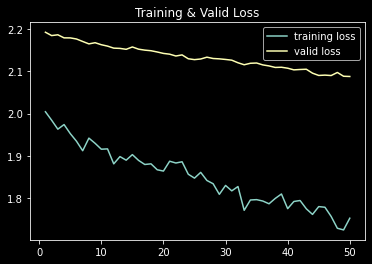

In [160]:
plot_loss(history)

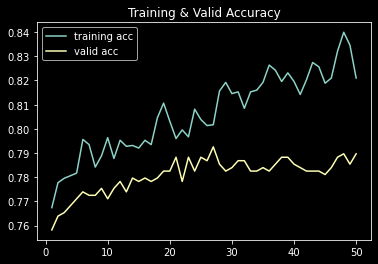

In [161]:
plot_acc(history)

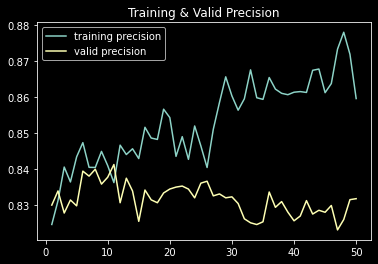

In [162]:
plot_precision(history)

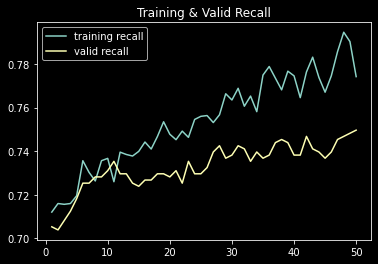

In [163]:
plot_recall(history)

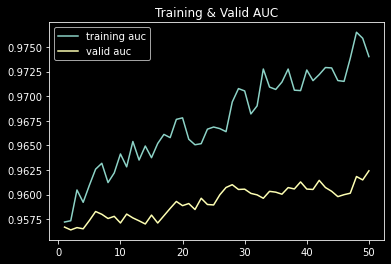

In [164]:
plot_auc(history)

### Evaluate model

In [165]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 516ms/step - loss: 1.7627 - categorical_accuracy: 0.7897 - precision: 0.8317 - recall: 0.7496 - auc: 0.9624


[1.7626938386396929, 0.78969955, 0.83174604, 0.7496424, 0.9624123]

In [166]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [167]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 447ms/step


In [168]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.97      0.97       359
         mild       0.48      0.62      0.54        68
     moderate       0.74      0.62      0.68       184
       severe       0.49      0.68      0.57        34
proliferative       0.48      0.44      0.46        54

     accuracy                           0.79       699
    macro avg       0.63      0.67      0.64       699
 weighted avg       0.80      0.79      0.79       699



In [169]:
confusion_matrix(y_true, y_pred)

array([[348,   9,   1,   0,   1],
       [  5,  42,  19,   0,   2],
       [  5,  31, 115,  16,  17],
       [  0,   1,   4,  23,   6],
       [  0,   5,  17,   8,  24]], dtype=int64)

# Fold 5

## Train classifier

In [170]:
try:
    del (model)
except:
    pass

In [171]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [172]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.jpeg,0
7,00a8624548a9.jpeg,2
8,00b74780d31d.jpeg,2


In [173]:
if os.path.isdir(
        os.path.join(dir_base, 'models/kfold_rescale_jpeg_72/fold' +
                     str(fold))) == False:
    os.mkdir(
        os.path.join(dir_base,
                     'models/kfold_rescale_jpeg_72/fold' + str(fold)))

save_dir = os.path.join(dir_base,
                        'models/kfold_rescale_jpeg_72/fold' + str(fold))

In [174]:
conv_base, model = create_model()

In [175]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_init),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [176]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_head),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [177]:
history = model.fit(train_generator,
                    epochs=epoch_init,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7330 - categorical_accuracy: 0.4821 - precision: 0.5656 - recall: 0.3957 - auc: 0.7697
Epoch 00001: val_loss improved from inf to 10.06543, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 10.7329 - categorical_accuracy: 0.4816 - precision: 0.5662 - recall: 0.3955 - auc: 0.7698 - val_loss: 10.0654 - val_categorical_accuracy: 0.6237 - val_precision: 0.8746 - val_recall: 0.4092 - val_auc: 0.8822
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0716 - categorical_accuracy: 0.5688 - precision: 0.6532 - recall: 0.4922 - auc: 0.8394
Epoch 00002: val_loss improved from 10.06543 to 9.65445, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.0276 - categorical_accuracy: 0.6993 - precision: 0.7629 - recall: 0.6325 - auc: 0.9287
Epoch 00015: val_loss improved from 6.24317 to 6.02927, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_classifier.h5
88/88 [==============================] - 124s 1s/step - loss: 6.0235 - categorical_accuracy: 0.6995 - precision: 0.7630 - recall: 0.6327 - auc: 0.9287 - val_loss: 6.0293 - val_categorical_accuracy: 0.7053 - val_precision: 0.8000 - val_recall: 0.6180 - val_auc: 0.9389
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8782 - categorical_accuracy: 0.6957 - precision: 0.7620 - recall: 0.6249 - auc: 0.9246
Epoch 00016: val_loss improved from 6.02927 to 5.81117, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_classifier.h5
88/88 [==============================] - 123s 1s/step - loss: 5.8766 - categorical_accuracy: 0.6967 

87/88 [============================>.] - ETA: 1s - loss: 2.3657 - categorical_accuracy: 0.7604 - precision: 0.8248 - recall: 0.6957 - auc: 0.9536
Epoch 00043: val_loss improved from 2.66496 to 2.61402, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_classifier.h5
88/88 [==============================] - 123s 1s/step - loss: 2.3642 - categorical_accuracy: 0.7592 - precision: 0.8249 - recall: 0.6952 - auc: 0.9535 - val_loss: 2.6140 - val_categorical_accuracy: 0.7225 - val_precision: 0.7993 - val_recall: 0.6381 - val_auc: 0.9419
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.2816 - categorical_accuracy: 0.7644 - precision: 0.8249 - recall: 0.6997 - auc: 0.9553
Epoch 00044: val_loss improved from 2.61402 to 2.53572, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_classifier.h5
88/88 [==============================] - 125s 1s/step - loss: 2.2817 - categorical_accuracy: 0.7631 - precision:

In [178]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

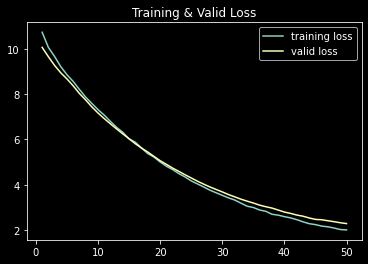

In [179]:
plot_loss(history)

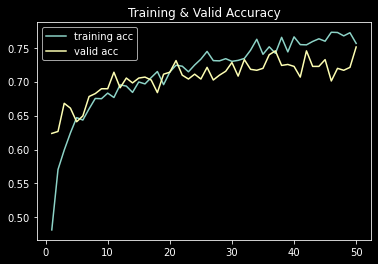

In [180]:
plot_acc(history)

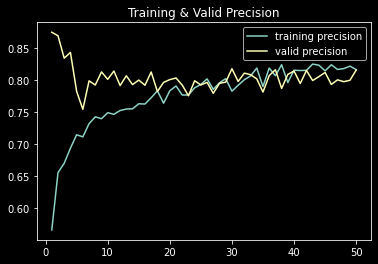

In [181]:
plot_precision(history)

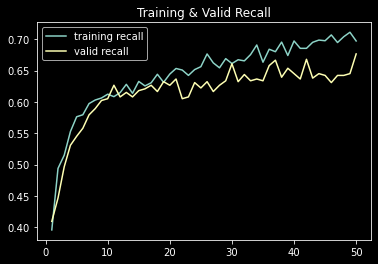

In [182]:
plot_recall(history)

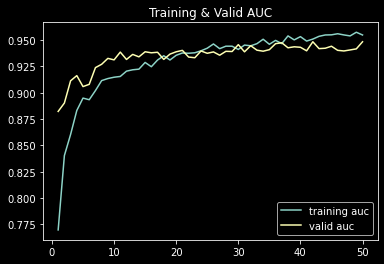

In [183]:
plot_auc(history)

### Evaluate model

In [184]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 686ms/step - loss: 1.8905 - categorical_accuracy: 0.7511 - precision: 0.8155 - recall: 0.6767 - auc: 0.9484


[1.8905433470552617, 0.75107294, 0.81551725, 0.676681, 0.9483602]

In [185]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [186]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 438ms/step


In [187]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       360
         mild       0.51      0.55      0.53        67
     moderate       0.75      0.53      0.62       184
       severe       0.23      0.38      0.29        34
proliferative       0.35      0.48      0.41        54

     accuracy                           0.75       699
    macro avg       0.56      0.58      0.56       699
 weighted avg       0.78      0.75      0.76       699



In [188]:
confusion_matrix(y_true, y_pred)

array([[352,   1,   5,   0,   2],
       [  9,  37,  12,   3,   6],
       [  6,  25,  97,  28,  28],
       [  0,   0,   9,  13,  12],
       [  0,   9,   7,  12,  26]], dtype=int64)

## Fine Tune

In [189]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [190]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_tune),
              loss=losses.CategoricalCrossentropy(),
              metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [191]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, save_csv),
                        separator=',',
                        append=True),
    callbacks.ModelCheckpoint(os.path.join(save_dir, save_best_train_body),
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)
]

In [192]:
history = model.fit(train_generator,
                    epochs=epoch_tune,
                    validation_data=valid_generator,
                    class_weight=dict_class_weight,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9229 - categorical_accuracy: 0.7810 - precision: 0.8405 - recall: 0.7177 - auc: 0.9615
Epoch 00001: val_loss improved from inf to 2.29089, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_fine_tune.h5
88/88 [==============================] - 138s 2s/step - loss: 1.9214 - categorical_accuracy: 0.7814 - precision: 0.8407 - recall: 0.7185 - auc: 0.9617 - val_loss: 2.2909 - val_categorical_accuracy: 0.7482 - val_precision: 0.8107 - val_recall: 0.6738 - val_auc: 0.9473
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9402 - categorical_accuracy: 0.7799 - precision: 0.8330 - recall: 0.7246 - auc: 0.9609
Epoch 00002: val_loss improved from 2.29089 to 2.28661, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_fine_tune.h5
88/88 [=========

88/88 [==============================] - 131s 1s/step - loss: 1.8534 - categorical_accuracy: 0.7949 - precision: 0.8416 - recall: 0.7328 - auc: 0.9654 - val_loss: 2.2565 - val_categorical_accuracy: 0.7496 - val_precision: 0.8057 - val_recall: 0.6881 - val_auc: 0.9490
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.8508 - categorical_accuracy: 0.8023 - precision: 0.8482 - recall: 0.7514 - auc: 0.9655
Epoch 00016: val_loss improved from 2.25650 to 2.25572, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_fine_tune.h5
88/88 [==============================] - 124s 1s/step - loss: 1.8504 - categorical_accuracy: 0.8014 - precision: 0.8471 - recall: 0.7499 - auc: 0.9653 - val_loss: 2.2557 - val_categorical_accuracy: 0.7468 - val_precision: 0.8017 - val_recall: 0.6881 - val_auc: 0.9489
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8455 - categorical_accuracy: 0.7929 - precision: 0.8354 - recall: 0.7355 - auc

Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.7560 - categorical_accuracy: 0.8229 - precision: 0.8623 - recall: 0.7716 - auc: 0.9719
Epoch 00031: val_loss did not improve from 2.23338
88/88 [==============================] - 121s 1s/step - loss: 1.7573 - categorical_accuracy: 0.8221 - precision: 0.8622 - recall: 0.7710 - auc: 0.9717 - val_loss: 2.2338 - val_categorical_accuracy: 0.7711 - val_precision: 0.8144 - val_recall: 0.7096 - val_auc: 0.9528
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.7815 - categorical_accuracy: 0.8157 - precision: 0.8552 - recall: 0.7662 - auc: 0.9699
Epoch 00032: val_loss did not improve from 2.23338
88/88 [==============================] - 121s 1s/step - loss: 1.7783 - categorical_accuracy: 0.8164 - precision: 0.8557 - recall: 0.7671 - auc: 0.9700 - val_loss: 2.2348 - val_categorical_accuracy: 0.7725 - val_precision: 0.8115 - val_recall: 0.7082 - val_auc: 0.9527
Epoch 33/50
87/88 [===========================

88/88 [==============================] - 123s 1s/step - loss: 1.7009 - categorical_accuracy: 0.8274 - precision: 0.8645 - recall: 0.7817 - auc: 0.9747 - val_loss: 2.2102 - val_categorical_accuracy: 0.7740 - val_precision: 0.8161 - val_recall: 0.7239 - val_auc: 0.9538
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.7296 - categorical_accuracy: 0.8200 - precision: 0.8587 - recall: 0.7752 - auc: 0.9738
Epoch 00047: val_loss improved from 2.21024 to 2.21023, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_rescale_jpeg_72/fold5\best_fine_tune.h5
88/88 [==============================] - 122s 1s/step - loss: 1.7278 - categorical_accuracy: 0.8199 - precision: 0.8587 - recall: 0.7749 - auc: 0.9738 - val_loss: 2.2102 - val_categorical_accuracy: 0.7768 - val_precision: 0.8129 - val_recall: 0.7210 - val_auc: 0.9539
Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.6974 - categorical_accuracy: 0.8316 - precision: 0.8644 - recall: 0.7853 - auc

In [193]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

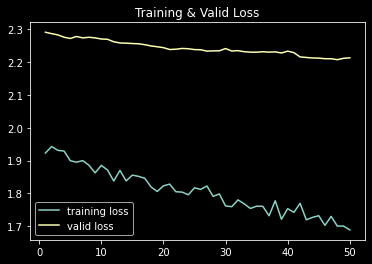

In [194]:
plot_loss(history)

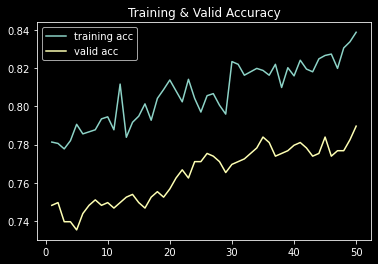

In [195]:
plot_acc(history)

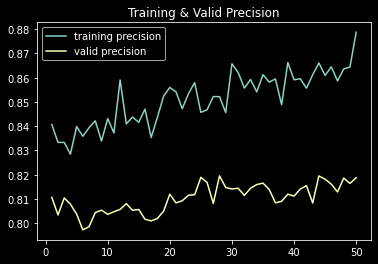

In [196]:
plot_precision(history)

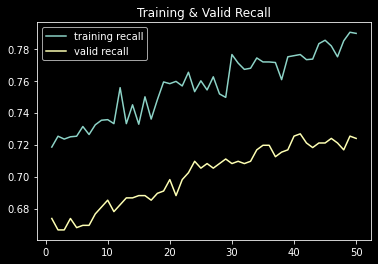

In [197]:
plot_recall(history)

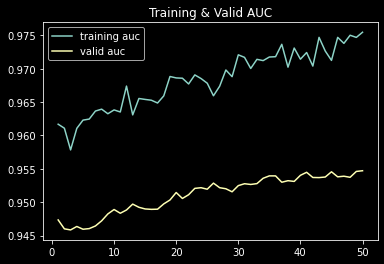

In [198]:
plot_auc(history)

### Evaluate model

In [199]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 503ms/step - loss: 1.7925 - categorical_accuracy: 0.7897 - precision: 0.8188 - recall: 0.7239 - auc: 0.9547


[1.7925355326045642, 0.78969955, 0.81877023, 0.72389126, 0.9547202]

In [200]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [201]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 10s 442ms/step


In [202]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=['normal', 'mild', 'moderate', 'severe',
                      'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       360
         mild       0.56      0.57      0.56        67
     moderate       0.78      0.64      0.70       184
       severe       0.30      0.38      0.33        34
proliferative       0.45      0.59      0.51        54

     accuracy                           0.79       699
    macro avg       0.61      0.63      0.62       699
 weighted avg       0.80      0.79      0.79       699



In [203]:
confusion_matrix(y_true, y_pred)

array([[352,   3,   3,   0,   2],
       [  9,  38,  12,   2,   6],
       [  5,  20, 117,  21,  21],
       [  0,   1,  10,  13,  10],
       [  0,   6,   8,   8,  32]], dtype=int64)